In [1]:
import torch
import numpy as np
from abcpy.output import Journal
import matplotlib.pyplot as plt
import pickle
from src.models.lorenz_96_model import Lorenz96SDE
from src.models.neural_lorenz_96_model import NeuralLorenz96SDE
from src.scoring_rules.scoring_rules import EnergyScore
from jax import jit, random
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from abcpy.continuousmodels import ProbabilisticModel, Continuous, InputConnector, Uniform, Normal
from abcpy.statistics import Statistics, Identity
import pickle
import functools
from einops import rearrange
import seaborn as sns 
from src.utils import transform_neural_lorenz_parameter
import matplotlib as mpl
import statistics
from math import sqrt
import scipy.stats as st

/home/minny/anaconda3/envs/GBLFI-final/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
params = {
   'text.usetex': False,
   'figure.figsize': [6.4, 4],
    'font.size': 9,
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'legend.fontsize': 8,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
   }

In [3]:
exp_list = (0,1,2,3,4)

sgnht = []
abc = []
abc_jnls = []
abc_ss = []
abc_ss_jnls = []
obs_list = []

for i in exp_list:
    obs_path = f'./stoch_l96_obs/samples_{i}.pt'

    with open(f'{i}_sgnht_stoch_l96_m_10.pickle', 'rb') as handle:
        ss_sgnht = pickle.load(handle)
        trans = ss_sgnht['config']['transformer']
        ss_sgnht_con = trans.inverse_transform(ss_sgnht['samples_uncon'], use_torch=True)

        sgnht.append(ss_sgnht_con)
        
    jnl = Journal.fromFile(f"./SMC_ABC/{i}_ABC_n-steps_25_n-samples_1000_n-sam-per-param_10.jnl")
    abc_jnls.append(jnl)
    abc.append(np.array(jnl.get_accepted_parameters()).reshape(1000,3))
    
    jnl_ss = Journal.fromFile(f"./SMC_ABC_SS/SimpLorenz96_{i+1}/ABC_inference/ABC_n-steps_25_n-samples_1000_n-sam-per-param_10.jnl")
    abc_ss_jnls.append(jnl_ss)
    abc_ss.append(np.array(jnl_ss.get_accepted_parameters()).reshape(1000,3))

    obs_list.append(torch.load(obs_path))

In [7]:
# total_sgnht_sims = []
# total_abc_sims = []
# total_abc_ss_sims = []

# for exp_idx, exp_num in enumerate(exp_list):
#     sgnht_sims = []
#     abc_sims = []
#     abc_ss_sims = []

#     for i in tqdm(range(1,1001)):
#         l96 = Lorenz96SDE()
#         sgnht_sims.append(l96.torch_forward_simulate(sgnht[exp_idx][-i,:], 500, normalise=False).detach())

#         l96 = Lorenz96SDE()
#         abc_sims.append(l96.torch_forward_simulate(abc[exp_idx][-i,:], 500, normalise=False).detach())

#         l96 = Lorenz96SDE()
#         abc_ss_sims.append(l96.torch_forward_simulate(abc[exp_idx][-i,:], 500, normalise=False).detach())

#     total_sgnht_sims.append(sgnht_sims)
#     total_abc_sims.append(abc_sims)
#     total_abc_ss_sims.append(abc_ss_sims)

#     total_abc_ss_sims.append(abc_ss_sims)
f = './simulations_for_metrics/'
with open(f+'abc_sims.pickle', 'rb') as handle:
    total_abc_sims = pickle.load(handle)

with open(f+'sgnht_sims.pickle', 'rb') as handle:
    total_sgnht_sims = pickle.load(handle)

with open(f+'abc_ss_sims.pickle', 'rb') as handle:
    total_abc_ss_sims = pickle.load(handle)

In [8]:
all_sgnht_scores = []
all_abc_scores = []
all_abc_ss_scores = []
es = EnergyScore(weight=1)

for idx, _ in enumerate(exp_list):
    total_sgnht_scores = []
    #20 * 8 = 160
    for sim in total_sgnht_sims[idx]:
        scores = [] #20 scores for each timestep
        for i in range(0,160,8): #0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,128,136,144,152
            scores.append(es.score(observations = obs_list[idx][:,i:i+8], simulations = sim[:,i:i+8], use_torch=True))
        total_sgnht_scores.append(scores) #1000 scores in total

    total_abc_scores = []
    #20 * 8 = 160
    for sim in total_abc_sims[idx]:
        scores = [] #20 scores for each timestep
        for i in range(0,160,8): #0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,128,136,144,152
            scores.append(es.score(observations = obs_list[idx][:,i:i+8], simulations = sim[:,i:i+8], use_torch=True))
        total_abc_scores.append(scores) #1000 scores in total


    total_abc_ss_scores = []
    #20 * 8 = 160
    for sim in total_abc_ss_sims[idx]:
        scores = [] #20 scores for each timestep
        for i in range(0,160,8): #0,8,16,24,32,40,48,56,64,72,80,88,96,104,112,120,128,136,144,152
            scores.append(es.score(observations = obs_list[idx][:,i:i+8], simulations = sim[:,i:i+8], use_torch=True))
        total_abc_ss_scores.append(scores) #1000 scores in total
    all_sgnht_scores.append(total_sgnht_scores)
    all_abc_scores.append(total_abc_scores)
    all_abc_ss_scores.append(total_abc_ss_scores)

In [9]:
# We average over the sims to get the average posterior predictive score
# np.array(all_sgnht_scores) : (5,1000,20) # Dataset, sims, ts
# np.array(all_abc_scores) : (5,1000,20)
ts = np.arange(1,21)
mean_sg_scores = np.array(all_sgnht_scores).mean(axis=1) # (5,20)
mean_abc_scores = np.array(all_abc_scores).mean(axis=1)
mean_abc_ss_scores = np.array(all_abc_ss_scores).mean(axis=1)

# From mean_sg_scores : (5,20)
# To ci_sg_scores : (20,3)
ci_sg_scores = []
ci_abc_scores = []
ci_abc_ss_scores = []
for i in range(20):
    #ci_sg = st.norm.interval(0.95, loc=np.mean(mean_sg_scores[:,i]), scale=st.sem(mean_sg_scores[:,i]))
    ci_sg = st.t.interval(0.95, len(mean_sg_scores[:,i])-1, loc=np.mean(mean_sg_scores[:,i]), scale=st.sem(mean_sg_scores[:,i]))

    #ci_abc = st.norm.interval(0.95, loc=np.mean(mean_abc_scores[:,i]), scale=st.sem(mean_abc_scores[:,i]))
    ci_abc = st.t.interval(0.95, len(mean_abc_scores[:,i])-1, loc=np.mean(mean_abc_scores[:,i]), scale=st.sem(mean_abc_scores[:,i]))

    ci_abc_ss = st.t.interval(0.95, len(mean_abc_ss_scores[:,i])-1, loc=np.mean(mean_abc_ss_scores[:,i]), scale=st.sem(mean_abc_ss_scores[:,i]))

    ci_sg_scores.append((np.mean(mean_sg_scores[:,i]), ci_sg[0], ci_sg[1]))
    ci_abc_scores.append((np.mean(mean_abc_scores[:,i]), ci_abc[0], ci_abc[1]))
    ci_abc_ss_scores.append((np.mean(mean_abc_ss_scores[:,i]), ci_abc_ss[0], ci_abc_ss[1]))

ci_sg_scores = np.array(ci_sg_scores)
ci_abc_scores = np.array(ci_abc_scores)
ci_abc_ss_scores = np.array(ci_abc_ss_scores)

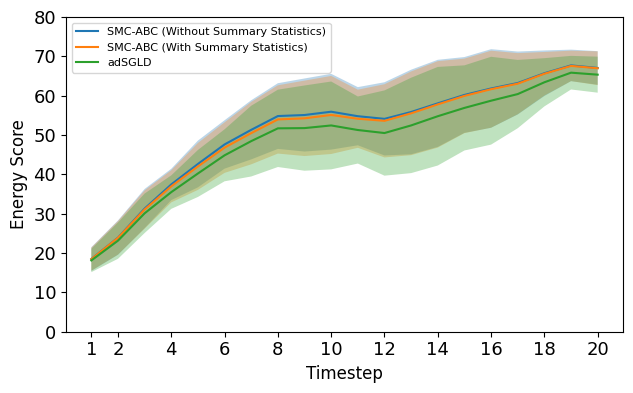

In [10]:
with mpl.rc_context(params):
    fig, ax = plt.subplots()

    plt.plot(ts,ci_abc_scores[:,0], label='SMC-ABC (Without Summary Statistics)')#, ls='-.')
    plt.fill_between(ts, (ci_abc_scores[:,2]), (ci_abc_scores[:,1]), alpha=.3)

    plt.plot(ts,ci_abc_ss_scores[:,0], label='SMC-ABC (With Summary Statistics)')#, ls='-.')
    plt.fill_between(ts, (ci_abc_ss_scores[:,2]), (ci_abc_ss_scores[:,1]), alpha=.3)

    plt.plot(ts,ci_sg_scores[:,0], label='adSGLD') #Use to be SG-NHT
    plt.fill_between(ts, (ci_sg_scores[:,2]), (ci_sg_scores[:,1]), alpha=.3)

    plt.legend(loc='upper left')
    plt.xlabel('Timestep')
    ax.set_ylim(0,80)
    ax.set_xticks(np.append(1,np.arange(2,21,2)))
    plt.ylabel('Energy Score') 
    fig.tight_layout()#rect=[0.2,0.2,.2,.2]) 
    #plt.show()
    plt.savefig("Posterior predictive ABC adSGLD.pdf", bbox_inches='tight')